<h2><center> <span style = "font-family: Babas; font-size: 2em;"> E-commerce Text Classification </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Part 2. TF-IDF Modeling </span> </center></h4>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Sugata Ghosh </span> </center></h4>

---

### Overview

The objective of the project is to classify [**e-commerce**](https://en.wikipedia.org/wiki/E-commerce) products into four categories, based on its description available in the e-commerce platforms. The categories are: `Electronics`, `Household`, `Books`, and `Clothing & Accessories`. We carried out the following steps in this notebook:

- Loaded the normalized dataset obtained from **Part 1. EDA and Text Normalization**, where we employed several [**text normalization**](https://en.wikipedia.org/wiki/Text_normalization) techniques, namely *convertion to lowercase*, *removal of whitespaces*, *removal of punctuations*, *removal of unicode characters*, *substitution of acronyms*, *substitution of contractions*, *removal of stop words*, *stemming and lemmatization*, *discardment of non-alphabetic words*, *retainment of relevant parts of speech*, *removal of additional stop words*

- Used [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) vectorizer on normalized descriptions for **text vectorization**

- Used several classifiers, namely *logistic regression*, *k-nearest neighbors classifier*, *decision tree*, *support vector machine with linear kernel*, *random forest*, *stochastic gradient descent classifier*, *ridge classifier*, *XGBoost* and *AdaBoost* for **baseline modeling**

- Performed [**hyperparameter tuning**](https://en.wikipedia.org/wiki/Hyperparameter_optimization) on the [**support vector machine**](https://en.wikipedia.org/wiki/Support-vector_machine) classifier with **linear kernel**

- Employed the model with the highest validation accuracy to predict the labels of the test observations and obtained a test accuracy of $0.957965$

---

### Contents

- **Data**
    - Normalized Data
    - Train-Validation-Test Split
- **TF-IDF Model**
    - Text Vectorization
    - Baseline Modeling
    - Hyperparameter Tuning
- **Final Prediction and Evaluation**
- **Acknowledgements**
- **References**

### Importing libraries

In [1]:
# File system manangement
import time, psutil, os

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

### Runtime and memory usage

In [2]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# Data

- **Normalized Data**
- **Train-Validation-Test Split**

## Normalized Data

Original dataset source: **https://doi.org/10.5281/zenodo.3355823**

Kaggle dataset: **https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification**

The product descriptions in the original dataset have been processed through a number of pre-processing steps in **Part 1. EDA and Text Normalization**. These steps are as follows (in order):
- **Convertion to lowercase**
- **Removal of whitespaces**
- **Removal of punctuations**
- **Removal of unicode characters**
- **Substitution of acronyms**
- **Substitution of contractions**
- **Removal of stop words**
- **Stemming and lemmatization**
- **Discardment of non-alphabetic words**
- **Retainment of relevant parts of speech**
- **Removal of additional stop words**

We did not employ the **spelling correction** step as it takes a massive amount of time to run on large datasets. Furthermore, the label dataset is manually encoded with the following scheme:
- **Electronics** $\mapsto$ $0$
- **Household** $\mapsto$ $1$
- **Books** $\mapsto$ $2$
- **Clothing & Accessories** $\mapsto$ $3$

In this notebook, we import the dataset obtained after carrying out the above preprocessing steps.

In [3]:
# Loading the normalized data
data = pd.read_csv('https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/Dataset/ecommerceDataset_normalized.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)), 
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.42 MB
Dataset shape    (27802, 2)


,normalized description,label
0,paper plane design frame wall hang office deco...,1
1,framed paint wood inch inch effect print textu...,1
2,saf texture art print frame paint cm cm cm set...,1
3,saf flower print frame paint inch inch texture...,1
4,gift india wooden birthday personalize gift in...,1
...,...,...
27797,micromax bharat impact displayscratch proof pr...,0
27798,lumia gb lumia experience power window price h...,0
27799,lumia gb colourblack product description defin...,0
27800,karbonn titanium titanium wind performance pow...,0


In [4]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values      4
Number of duplicate observations              688


The $4$ missing values correspond to the product descriptions that were originally non-empty but became empty after the preprocessing steps. Similarly, the $688$ duplicate observations were originally distinct but coincided with one or more observations following the preprocessing steps.

In [5]:
data.dropna(inplace = True) # Dropping observations with missing values
data.drop_duplicates(inplace = True) # Dropping duplicate observations
data.reset_index(drop = True, inplace = True) # Resetting index

We split the dataset based on the target classes, in order to see how different textual attributes vary across classes.

In [6]:
# Splitting the dataset by label
data_e = data[data['label'] == 0] # Electronics
data_h = data[data['label'] == 1] # Household
data_b = data[data['label'] == 2] # Books
data_c = data[data['label'] == 3] # Clothing & Accessories

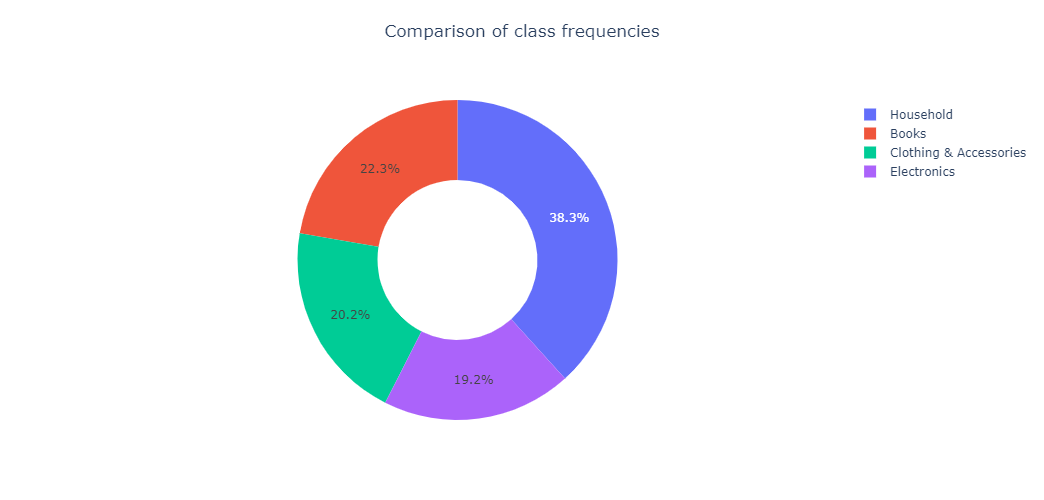

In [7]:
# Visualization of class frequencies
values = np.array([len(data_e), len(data_h), len(data_b), len(data_c)])
labels = ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of class frequencies"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
fig.show()

## Train-Validation-Test Split

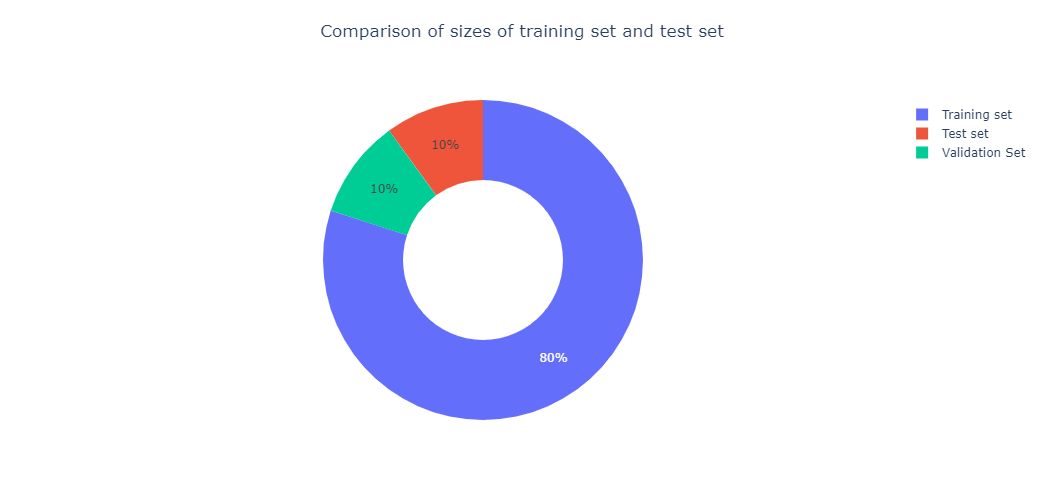

In [8]:
# Feature-target split
X, y = data.drop('label', axis = 1), data['label']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of sizes of training set and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
fig.show()

# TF-IDF Model

- **Text Vectorization**
- **Baseline Modeling**
- **Hyperparameter Tuning**

In the context of [**information retrieval**](https://en.wikipedia.org/wiki/Information_retrieval), **TF-IDF** (short for **term frequency-inverse document frequency**), is a numerical statistic that is intended to reflect how important a word is to a document in a collection or [**corpus**](https://en.wikipedia.org/wiki/Text_corpus). It is often used as a weighting factor in searches of **information retrieval**, [**text mining**](https://en.wikipedia.org/wiki/Text_mining), and [**user modeling**](https://en.wikipedia.org/wiki/User_modeling). The **TF-IDF** value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. The term is composed of two factors, **TF** and **IDF**.

[**term frequency**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Term_frequency) **(TF)** is the relative frequency of a term within a given document. It is obtained as the number of times a word appears in a text, divided by the total number of words appearing in the text. Mathematically, it is given by

$$ \text{TF}\left(t, d\right) := \frac{f_{t, d}}{\sum_{t' \in d} f_{t', d}},$$

where $f_{t, d}$ is the number of times that term $t$ appears in the document $d$. Note that the denominator is simply the total number of terms in the document $d$, counting every instance of a given term.

[**inverse document frequency**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency) **(IDF)** measures how common or rare a word is across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word, obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that ratio. Mathematically, it is given by

$$ \text{IDF}\left(t, D\right) := \log{\frac{N}{\left\vert \left\{ d \in D : t \in d \right\} \right\vert}},$$

where $\left\vert S \right\vert$ denotes the cardinality of the set $S$, $N$ is the total number of documents in the corpus, i.e. $N = \left\vert D \right\vert$, and the denominator $\left\vert \left\{ d \in D : t \in d \right\} \right\vert$ is the number of documents where the term $t$ appears. If $t$ is not in the corpus, then $\text{IDF}\left(t, D\right)$ will become undefined. To avoid this, the denominator is often adjusted to $1 + \left\vert \left\{ d \in D : t \in d \right\} \right\vert$. **TF-IDF is the product of the two terms TF and IDF**, i.e.

$$\text{TF-IDF}\left(t, d, D\right) := \text{TF}\left(t, d\right) \times \text{IDF}\left(t, D\right).$$

**It objectively evaluates how relevant a word is to a text in a collection of texts, taking into consideration that some words appear more frequently in general.**

## Text Vectorization

In order to perform machine learning on text data, we must transform the documents into vector representations. In [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing), **text vectorization** is the process of converting words, sentences, or even larger units of text data to numerical vectors.

In [9]:
# Features and labels
X_train, y_train = data_train['normalized description'].tolist(), data_train['label'].tolist()
X_val, y_val = data_val['normalized description'].tolist(), data_val['label'].tolist()
X_test, y_test = data_test['normalized description'].tolist(), data_test['label'].tolist()

In [10]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train)
X_val_tfidf = TfidfVec.transform(X_val)
X_test_tfidf = TfidfVec.transform(X_test)

## Baseline Modeling

In [11]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier()
]

In [12]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
    
    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [13]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
3,Linear SVM,0.978331,0.943563
6,Ridge Classifier,0.983402,0.942457
5,SGD Classifier,0.967958,0.941719
0,Logistic Regression,0.966713,0.935448
4,Random Forest,0.999908,0.923644
7,XGBoost,0.961918,0.922907
1,KNN Classifier,0.913877,0.903726
2,Decision Tree,0.999908,0.860568
8,AdaBoost,0.810235,0.793434


## Hyperparameter Tuning

We perform [**hyperparameter tuning**](https://en.wikipedia.org/wiki/Hyperparameter_optimization) on the best performing baseline model.

In [14]:
# Hyperparameter tuning for XGBoost
svm_classifier = svm.SVC()
params_svm = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100]
}

best_model_svm, best_params, best_score, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0
for g in ParameterGrid(params_svm):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    svm_classifier.set_params(**g)
    svm_classifier.fit(X_train_tfidf, y_train)
    y_train_pred, y_val_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score:
        best_params, best_score = g, score_val

best_model = svm.SVC()
best_model.set_params(**best_params)
print(f"Best model: {best_model}")
print(" ")
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_score}")

Gridpoint #1: {'C': 0.1, 'kernel': 'linear'}
Training accuracy: 0.9337482710926694, Validation accuracy: 0.9133161195130948, Runtime: 3m8s
 
Gridpoint #2: {'C': 1, 'kernel': 'linear'}
Training accuracy: 0.9783310281235592, Validation accuracy: 0.9435632607893766, Runtime: 1m57s
 
Gridpoint #3: {'C': 10, 'kernel': 'linear'}
Training accuracy: 0.998248040571692, Validation accuracy: 0.9376613795647363, Runtime: 2m3s
 
Gridpoint #4: {'C': 100, 'kernel': 'linear'}
Training accuracy: 0.9994006454587367, Validation accuracy: 0.9339727037993361, Runtime: 1m59s
 
Best model: SVC(C=1, kernel='linear')
 
Best parameters: {'C': 1, 'kernel': 'linear'}
Best validation accuracy: 0.9435632607893766


# Final Prediction and Evaluation

In [15]:
# Function to compute and print confusion matrix
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1, 2, 3] # ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(4), range(4))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

Test accuracy    0.957965
 


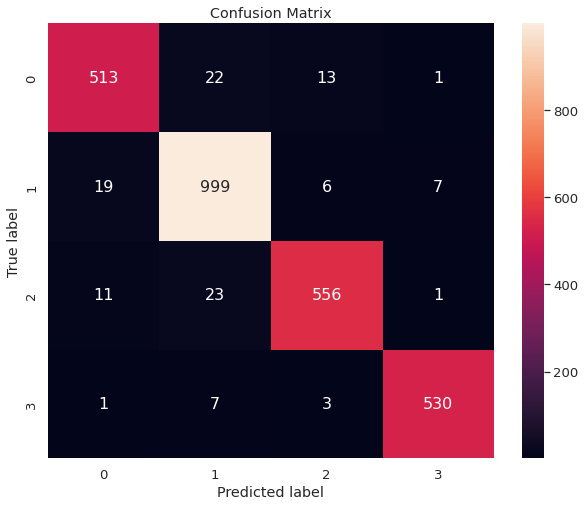

In [16]:
# Prediction and evaluation on test set
best_model.fit(X_train_tfidf, y_train)
y_test_pred = best_model.predict(X_test_tfidf)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix
print(" ")

# Acknowledgements

- [**Ecommerce Text Classification**](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification) dataset
- [**Gautam. (2019). E commerce text dataset (version - 2) [Data set]. *Zenodo*.**](https://doi.org/10.5281/zenodo.3355823)

# References

- [**Acronym**](https://en.wikipedia.org/wiki/Acronym)
- [**E-commerce**](https://en.wikipedia.org/wiki/E-commerce)
- [**Hyperparameter optimization**](https://en.wikipedia.org/wiki/Hyperparameter_optimization)
- [**Inverse document frequency**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency)
- [**Lemmatization**](https://en.wikipedia.org/wiki/Lemmatisation)
- [**List of English contractions**](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions)
- [**Natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing)
- [**Part of speech**](https://en.wikipedia.org/wiki/Part_of_speech)
- [**Stemming**](https://en.wikipedia.org/wiki/Stemming)
- [**Stop word**](https://en.wikipedia.org/wiki/Stop_word)
- [**Support vector machine**](https://en.wikipedia.org/wiki/Support-vector_machine)
- [**Term frequency**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Term_frequency)
- [**Text corpus**](https://en.wikipedia.org/wiki/Text_corpus)
- [**Text normalization**](https://en.wikipedia.org/wiki/Text_normalization)
- [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [17]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         899.09 seconds
Process memory usage         794.84 MB
